# LSTM for Time series prediction

What LSTM solves: Given the last few `n` samples of data in time, predict the next few `m` samples of data.

See https://colah.github.io/posts/2015-08-Understanding-LSTMs/ for more information about LSTMs. 

## Updates

* Data is now normalized in `[-1, 1]`. Turns out tanh performs best if data is normalized. As a result the model has a much lower MSE.
* For consistency with the other models, add "time of the day" (minute offset, 0-1440) as an input feature.

## Prelude

Import all the packages.

In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import collections
import math

# Part A. Data processing

## Import dataset

Import dataset into a pandas DataFrame.

`dataset.csv` is the Birmingham carpark dataset and should exist in the jupyter notebook directory.
Get it from https://archive.ics.uci.edu/ml/datasets/Parking+Birmingham

In [2]:
def import_dataset():
    with open('dataset.csv', 'r') as f:
        x = f.read().strip().split('\n')
    y = [x.split(',') for x in x]
    y = y[1:]  # First line is header
    SystemCodeNumber, Capacity, Occupancy, LastUpdated = zip(*y)
    Capacity = pd.to_numeric(Capacity)
    Occupancy = pd.to_numeric(Occupancy)
    LastUpdated = pd.to_datetime(LastUpdated)
    return pd.DataFrame({'SystemCodeNumber': SystemCodeNumber, 'Capacity': Capacity, 'Occupancy': Occupancy}, index=LastUpdated)

ds_import = import_dataset()
ds_import

,Capacity,Occupancy,SystemCodeNumber
2016-10-04 07:59:42,577,61,BHMBCCMKT01
2016-10-04 08:25:42,577,64,BHMBCCMKT01
2016-10-04 08:59:42,577,80,BHMBCCMKT01
2016-10-04 09:32:46,577,107,BHMBCCMKT01
2016-10-04 09:59:48,577,150,BHMBCCMKT01
2016-10-04 10:26:49,577,177,BHMBCCMKT01
2016-10-04 10:59:48,577,219,BHMBCCMKT01
2016-10-04 11:25:47,577,247,BHMBCCMKT01
2016-10-04 11:59:44,577,259,BHMBCCMKT01
2016-10-04 12:29:45,577,266,BHMBCCMKT01


## Split dataset into different carparks

At the same time, determine their capacity.

In [3]:
def split_into_carparks(dataset):
    "Output: { carpark_name: (dataset, capacity) }"
    carparks = dataset['SystemCodeNumber'].unique()
    out = {}
    for carpark in carparks:
        x = dataset.loc[dataset['SystemCodeNumber'] == carpark]
        capacity = x['Capacity'].iloc[0]
        assert x[x['Capacity'] != capacity].shape[0] == 0, 'Capacity is not the same for all rows!'
        out[carpark] = x['Occupancy'], capacity
    return out

ds_split = split_into_carparks(ds_import)
ds_split

{'BHMBCCMKT01': (2016-10-04 07:59:42     61
  2016-10-04 08:25:42     64
  2016-10-04 08:59:42     80
  2016-10-04 09:32:46    107
  2016-10-04 09:59:48    150
  2016-10-04 10:26:49    177
  2016-10-04 10:59:48    219
  2016-10-04 11:25:47    247
  2016-10-04 11:59:44    259
  2016-10-04 12:29:45    266
  2016-10-04 13:02:48    269
  2016-10-04 13:29:45    263
  2016-10-04 14:02:47    238
  2016-10-04 14:29:49    215
  2016-10-04 14:57:13    192
  2016-10-04 15:30:14    165
  2016-10-04 16:04:12    162
  2016-10-04 16:31:14    143
  2016-10-05 07:57:17     54
  2016-10-05 08:30:15     59
  2016-10-05 09:04:19     71
  2016-10-05 09:30:15     83
  2016-10-05 10:04:15    114
  2016-10-05 10:30:17    128
  2016-10-05 11:04:19    148
  2016-10-05 11:30:18    162
  2016-10-05 12:04:14    178
  2016-10-05 12:30:16    183
  2016-10-05 12:57:15    175
  2016-10-05 13:30:19    179
                        ... 
  2016-12-18 11:03:25     89
  2016-12-18 11:30:22    135
  2016-12-18 12:03:23    165

## Resample data

The Birmingham carpark dataset is updated every 30min from 8am to 5pm. However, the dataset doesn't actually contain samples at exactly 30min intervals. (e.g. first sample is taken at `2016-10-04 07:59:42`, and second sample is taken at `2016-10-04 07:59:42`). Furthermore, data is sometimes entirely missing for certain times.

We want the timings for each sample to be precisely at 8am, 8.30am, 9am, 9.30am etc. To do that we first upsample the dataset to 1min interval, then interpolate over missing data, and then downsample it down to 30min intervals. Set limit to 60 because we don't want to over-interpolate and fill in up to 1hr worth of junk data.

In [4]:
def resample_data(dataset):
    out = {}
    for k, (v, capacity) in dataset.items():
        out[k] = v.resample('1T').mean().interpolate(method='time',limit_direction='both', limit=60).resample('30T').mean().astype(np.float32), capacity
    return out

ds_resample = resample_data(ds_split)
ds_resample

{'BHMBCCMKT01': (2016-10-04 07:30:00     61.000000
  2016-10-04 08:00:00     62.906864
  2016-10-04 08:30:00     73.176468
  2016-10-04 09:00:00     92.681816
  2016-10-04 09:30:00    126.984848
  2016-10-04 10:00:00    165.554550
  2016-10-04 10:30:00    200.545456
  2016-10-04 11:00:00    235.450974
  2016-10-04 11:30:00    253.882355
  2016-10-04 12:00:00    262.616669
  2016-10-04 12:30:00    267.409088
  2016-10-04 13:00:00    266.190918
  2016-10-04 13:30:00    251.257568
  2016-10-04 14:00:00    227.342422
  2016-10-04 14:30:00    202.268188
  2016-10-04 15:00:00    177.681824
  2016-10-04 15:30:00    163.720581
  2016-10-04 16:00:00    154.405960
  2016-10-04 16:30:00    141.722733
  2016-10-04 17:00:00    138.819107
  2016-10-04 17:30:00    137.281311
  2016-10-04 18:00:00           NaN
  2016-10-04 18:30:00           NaN
  2016-10-04 19:00:00           NaN
  2016-10-04 19:30:00           NaN
  2016-10-04 20:00:00           NaN
  2016-10-04 20:30:00           NaN
  2016-10-04 

## Which carparks are missing too much data?

Some carparks are missing too much data to be usable.
Find out what they are by counting what percentage of their data between 8am to 5pm are `NaN`s.

In [5]:
def get_missing_data_percent(dataset):
    out = []
    for (k, (v, capacity)) in dataset.items():
        x = v.between_time('08:00', '17:00')
        out.append((x[x.isnull()].shape[0] / float(x.shape[0]) * 100, k))
    return out

print('\n'.join(repr(x) for x in sorted(get_missing_data_percent(ds_resample))))

(5.266757865937072, 'BHMBCCMKT01')
(5.266757865937072, 'BHMBCCTHL01')
(5.266757865937072, 'BHMEURBRD01')
(5.266757865937072, 'BHMMBMMBX01')
(5.266757865937072, 'BHMNCPNST01')
(5.266757865937072, 'Broad Street')
(5.266757865937072, 'Others-CCCPS105a')
(5.266757865937072, 'Others-CCCPS119a')
(5.266757865937072, 'Others-CCCPS135a')
(5.266757865937072, 'Others-CCCPS202')
(5.266757865937072, 'Others-CCCPS8')
(5.266757865937072, 'Others-CCCPS98')
(5.266757865937072, 'Shopping')
(5.403556771545827, 'BHMNCPHST01')
(6.566347469220246, 'BHMBCCSNH01')
(6.566347469220246, 'BHMNCPLDH01')
(6.566347469220246, 'Others-CCCPS133')
(6.6347469220246245, 'BHMNCPPLS01')
(7.865937072503421, 'BHMBCCPST01')
(7.865937072503421, 'BHMEURBRD02')
(9.537366548042705, 'NIA Car Parks')
(9.537366548042705, 'NIA South')
(14.36388508891929, 'BHMBRCBRG01')
(14.36388508891929, 'BHMBRCBRG02')
(14.36388508891929, 'BHMBRCBRG03')
(14.36388508891929, 'Bull Ring')
(14.432284541723666, 'BHMNCPRAN01')
(16.8141592920354, 'BHMBRTARC

## Remove carparks missing too much data

For (hopefully) good results, we remove carparks that have above 6% NANs.

In [6]:
def remove_bad_datasets(dataset, crit=6):
    out = {}
    for p, k in get_missing_data_percent(dataset):
        if p >= crit:
            continue
        out[k] = dataset[k]
    return out

ds_badrm = remove_bad_datasets(ds_resample)
ds_badrm

{'BHMBCCMKT01': (2016-10-04 07:30:00     61.000000
  2016-10-04 08:00:00     62.906864
  2016-10-04 08:30:00     73.176468
  2016-10-04 09:00:00     92.681816
  2016-10-04 09:30:00    126.984848
  2016-10-04 10:00:00    165.554550
  2016-10-04 10:30:00    200.545456
  2016-10-04 11:00:00    235.450974
  2016-10-04 11:30:00    253.882355
  2016-10-04 12:00:00    262.616669
  2016-10-04 12:30:00    267.409088
  2016-10-04 13:00:00    266.190918
  2016-10-04 13:30:00    251.257568
  2016-10-04 14:00:00    227.342422
  2016-10-04 14:30:00    202.268188
  2016-10-04 15:00:00    177.681824
  2016-10-04 15:30:00    163.720581
  2016-10-04 16:00:00    154.405960
  2016-10-04 16:30:00    141.722733
  2016-10-04 17:00:00    138.819107
  2016-10-04 17:30:00    137.281311
  2016-10-04 18:00:00           NaN
  2016-10-04 18:30:00           NaN
  2016-10-04 19:00:00           NaN
  2016-10-04 19:30:00           NaN
  2016-10-04 20:00:00           NaN
  2016-10-04 20:30:00           NaN
  2016-10-04 

## Finally fill in all missing data

Finally, use interpolation to fill in all missing data.
This includes the timings for which data does not simply exist (5pm to 8am).

In [7]:
def fill_in_missing_data(dataset):
    out = {}
    for k, (v, capacity) in dataset.items():
        out[k] = v.interpolate(method='linear'), capacity
    return out

ds_filled = fill_in_missing_data(ds_badrm)
dataset = ds_filled
ds_filled

{'BHMBCCMKT01': (2016-10-04 07:30:00     61.000000
  2016-10-04 08:00:00     62.906864
  2016-10-04 08:30:00     73.176468
  2016-10-04 09:00:00     92.681816
  2016-10-04 09:30:00    126.984848
  2016-10-04 10:00:00    165.554550
  2016-10-04 10:30:00    200.545456
  2016-10-04 11:00:00    235.450974
  2016-10-04 11:30:00    253.882355
  2016-10-04 12:00:00    262.616669
  2016-10-04 12:30:00    267.409088
  2016-10-04 13:00:00    266.190918
  2016-10-04 13:30:00    251.257568
  2016-10-04 14:00:00    227.342422
  2016-10-04 14:30:00    202.268188
  2016-10-04 15:00:00    177.681824
  2016-10-04 15:30:00    163.720581
  2016-10-04 16:00:00    154.405960
  2016-10-04 16:30:00    141.722733
  2016-10-04 17:00:00    138.819107
  2016-10-04 17:30:00    137.281311
  2016-10-04 18:00:00    134.296280
  2016-10-04 18:30:00    131.311264
  2016-10-04 19:00:00    128.326233
  2016-10-04 19:30:00    125.341209
  2016-10-04 20:00:00    122.356178
  2016-10-04 20:30:00    119.371155
  2016-10-04 

## Normalize data to [-1, 1]

This is needed for the LSTM model to perform well.

In [8]:
def rescale(dataset):
    out = {}
    for k, (v, capacity) in dataset.items():
        out[k] = (v / float(capacity)) * 2.0 - 1.0, capacity
    return out

ds_rescale = rescale(ds_filled)
dataset = ds_rescale
ds_rescale

{'BHMBCCMKT01': (2016-10-04 07:30:00   -0.788562
  2016-10-04 08:00:00   -0.781952
  2016-10-04 08:30:00   -0.746355
  2016-10-04 09:00:00   -0.678746
  2016-10-04 09:30:00   -0.559845
  2016-10-04 10:00:00   -0.426154
  2016-10-04 10:30:00   -0.304868
  2016-10-04 11:00:00   -0.183879
  2016-10-04 11:30:00   -0.119992
  2016-10-04 12:00:00   -0.089717
  2016-10-04 12:30:00   -0.073105
  2016-10-04 13:00:00   -0.077328
  2016-10-04 13:30:00   -0.129090
  2016-10-04 14:00:00   -0.211985
  2016-10-04 14:30:00   -0.298897
  2016-10-04 15:00:00   -0.384118
  2016-10-04 15:30:00   -0.432511
  2016-10-04 16:00:00   -0.464797
  2016-10-04 16:30:00   -0.508760
  2016-10-04 17:00:00   -0.518825
  2016-10-04 17:30:00   -0.524155
  2016-10-04 18:00:00   -0.534502
  2016-10-04 18:30:00   -0.544848
  2016-10-04 19:00:00   -0.555195
  2016-10-04 19:30:00   -0.565542
  2016-10-04 20:00:00   -0.575888
  2016-10-04 20:30:00   -0.586235
  2016-10-04 21:00:00   -0.596582
  2016-10-04 21:30:00   -0.606929

In [9]:
def add_min_of_day(dataset):
    out = {}
    for k, (v, capacity) in dataset.items():
        out[k] = v.to_frame('Occupancy').assign(MinOfDay=((v.index.hour * 60 + v.index.minute) / (24.0 * 60)) * 2.0 - 1.0), capacity
    return out

ds_minofday = add_min_of_day(ds_rescale)
dataset = ds_minofday
ds_minofday

{'BHMBCCMKT01': (                     Occupancy  MinOfDay
  2016-10-04 07:30:00  -0.788562 -0.375000
  2016-10-04 08:00:00  -0.781952 -0.333333
  2016-10-04 08:30:00  -0.746355 -0.291667
  2016-10-04 09:00:00  -0.678746 -0.250000
  2016-10-04 09:30:00  -0.559845 -0.208333
  2016-10-04 10:00:00  -0.426154 -0.166667
  2016-10-04 10:30:00  -0.304868 -0.125000
  2016-10-04 11:00:00  -0.183879 -0.083333
  2016-10-04 11:30:00  -0.119992 -0.041667
  2016-10-04 12:00:00  -0.089717  0.000000
  2016-10-04 12:30:00  -0.073105  0.041667
  2016-10-04 13:00:00  -0.077328  0.083333
  2016-10-04 13:30:00  -0.129090  0.125000
  2016-10-04 14:00:00  -0.211985  0.166667
  2016-10-04 14:30:00  -0.298897  0.208333
  2016-10-04 15:00:00  -0.384118  0.250000
  2016-10-04 15:30:00  -0.432511  0.291667
  2016-10-04 16:00:00  -0.464797  0.333333
  2016-10-04 16:30:00  -0.508760  0.375000
  2016-10-04 17:00:00  -0.518825  0.416667
  2016-10-04 17:30:00  -0.524155  0.458333
  2016-10-04 18:00:00  -0.534502  0.500

## Plot the data

Finally, plot the data to get a sense of all the data.

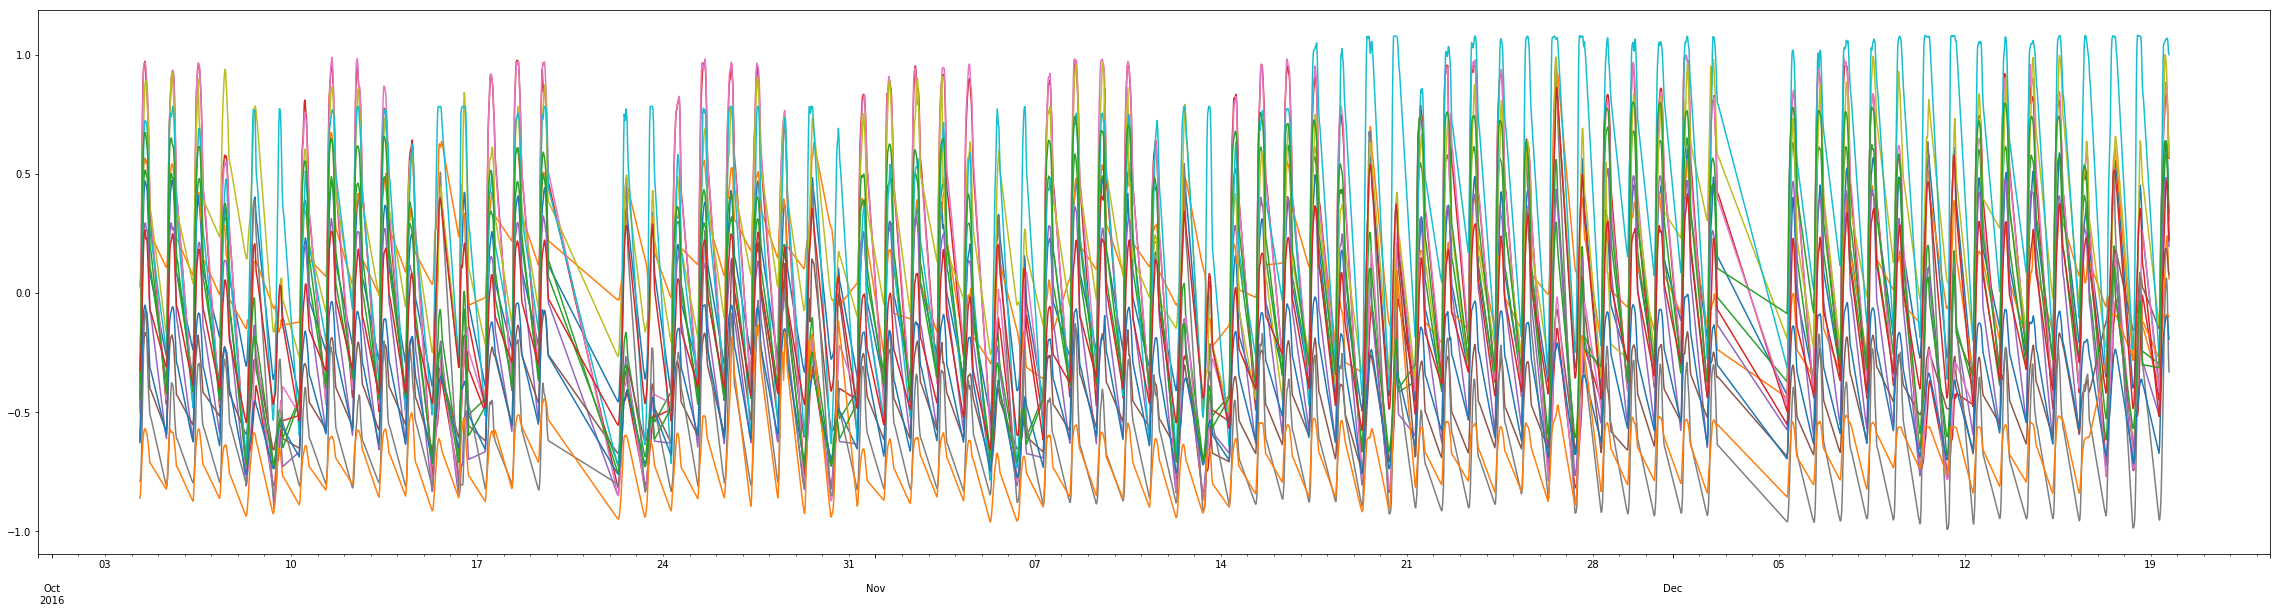

In [11]:
for k, (v, capacity) in ds_rescale.items():
    v.plot(figsize=(40, 10))

# Part B. Machine Learning

## `split_by_week()` -- Training/Validation set split helper function

For training and validation, we first split carpark data into *weeks*. The specified number of weeks will be used for validation, and the other weeks are used for training.

In [10]:
def split_by_week(dataset, validation_size=2):
    """
    Input: (DataFrame, capacity)
    Output: (DataFrame for training, DataFrame for validation, capacity)
    """
    v, capacity = dataset
    groups = list(d for _, d in v.groupby(v.index.weekofyear))
    return (pd.concat(groups[:-validation_size]), pd.concat(groups[-validation_size:]), capacity)

## `genslide()` -- Sliding window construction helper function

LSTM works by passing it `t - 1`, `t - 2`, `t - n` past data elements, and then asking it to predict `t`, `t + 1` ... `t + m - 1`.
To do this we need a helper function to generate a sliding window of `n + m` elements over the data.

In [11]:
def genslide(data, n, m):
    """input: numpy array with shape (numrows, numcols)
    output: (inputs, targets), where inputs is a numpy array with shape (numrows - (n + m) + 1, n, numcols)
    and targets is a numpy array with shape (numrows - (n + m) + 1, m * numcols)
    Notice for targets that the last two shape components are flattened.
    """
    assert data.ndim == 2 or data.ndim == 1, "input must be numpy array with shape (numrows, numcols). ndim is {0}".format(data.ndim)
    if data.ndim == 1:
        data = data.reshape(data.shape[0], 1)
    numrows, numcols = data.shape
    outrows = max(numrows - (n + m) + 1, 0)
    out_inputs = np.empty((outrows, n, numcols), dtype=np.float32)
    out_targets = np.empty((outrows, m, numcols), dtype=np.float32)
    for i in range(0, outrows):
        out_inputs[i] = data[i:i+n]
        out_targets[i] = data[i+n:i+n+m]
    out_targets = out_targets.reshape(outrows, m * numcols)
    assert out_inputs.shape == (outrows, n, numcols)
    assert out_targets.shape == (outrows, m * numcols)
    return out_inputs, out_targets

## `train_model()` -- Model setup and training helper function

We use mean squared error as the error measure.

In [12]:
def train_model(train_data, eval_data, n, m, num_lstm_layers, hidden_size, batch_size, epochs):
    """
    data: Pandas DataFrame containing the training carpark data.
    n: Number of past data points
    m: Number of output data points to predict
    hidden_size: The number of LSTM units
    """
    train_data_inputs, train_data_targets = genslide(train_data.values, n, m)
    eval_data_inputs, eval_data_targets = genslide(eval_data.values, n, m)
    assert train_data_inputs.ndim == 3
    assert train_data_targets.ndim == 2
    assert eval_data_inputs.ndim == 3
    assert eval_data_targets.ndim == 2
    seqs = []
    lstmLayerType = tf.keras.layers.CuDNNLSTM if tf.test.is_gpu_available(cuda_only=True) else tf.keras.layers.LSTM
    for i in range(num_lstm_layers):
        seqs.append(lstmLayerType(hidden_size, return_sequences=(i != num_lstm_layers - 1)))
    seqs.append(tf.keras.layers.Dense(train_data_targets.shape[1]))
    model = tf.keras.Sequential(seqs)
    model.compile(loss='mean_squared_error', optimizer=tf.train.RMSPropOptimizer(0.001))
    cbs = []
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('./tmp.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
    cbs.append(checkpoint_cb)
    history = model.fit(train_data_inputs, train_data_targets, validation_data=(eval_data_inputs, eval_data_targets), batch_size=batch_size, epochs=epochs, callbacks=cbs)
    model.load_weights('./tmp.hdf5')
    return model, history

## `train_plot()` -- Plot loss vs val_loss over training epochs

In [13]:
def train_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.yscale('log')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

## `evaluate_model()` -- Helper function for evaluating model by calculating mean squared error

In [14]:
def evaluate_model(model, data, n, m, batch_size):
    """
    model: Trained model
    data: Pandas dataframe containing carpark data for evaluation
    Returns: (np.float64) mean squared error
    """
    data_inputs, data_targets = genslide(data.values, n, m)
    assert data_inputs.ndim == 3
    assert data_targets.ndim == 2
    return model.evaluate(data_inputs, data_targets, batch_size=batch_size)

## `evaluate_model_plot()` -- Helper function for evaluating model by plotting predicted + actual on graph

In [27]:
def evaluate_model_plot(model, data, n, m, fn=None):
    data_inputs, data_targets = genslide(data.values, n, m)
    _, _, numcols = data_inputs.shape
    out_data = []
    out_indexes = []
    for i, (inp, tgt) in enumerate(zip(data_inputs, data_targets)):
        out_indexes.extend(data.index[i + n + z] for z in range(m))
        inp = inp.reshape(1, *inp.shape)
        vals = model.predict(inp)
        vals = vals.reshape(m, numcols)
        vals = vals[:, 0]
        out_data.extend(map(fn, vals) if fn else vals)
    df = pd.DataFrame(out_data, index=out_indexes)
    ax = df.plot(style='.', label='Predicated', figsize=(40, 20))
    data = data['Occupancy']
    if fn:
        data = data.map(fn)
    data.plot(ax=ax, style='+', label='Actual')
    ax.legend()

# Evaluation on BHMBCCMKT01

All experiments use a validation set size of *2 weeks*, and predict 2 hours ahead using 6 hours worth of prior data.

## Baseline: One LSTM Layer, 40 Units

In [18]:
%%time
data = dataset['BHMBCCMKT01']
n, m = 12, 4  # Predict 2 hour ahead using 6 hours worth of past data
train_set, eval_set, capacity = split_by_week(data, validation_size=2)
model, history = train_model(train_set, eval_set, n, m,
                    num_lstm_layers=1,
                    hidden_size=40,
                    batch_size=32,
                    epochs=500)

Train on 3282 samples, validate on 355 samples
Epoch 1/500
3282/3282 [==============================] - 1s 270us/step - loss: 0.3140 - val_loss: 0.1804
Epoch 2/500
3282/3282 [==============================] - 1s 161us/step - loss: 0.1326 - val_loss: 0.0869
Epoch 3/500
3282/3282 [==============================] - 1s 161us/step - loss: 0.0629 - val_loss: 0.0405
Epoch 4/500
3282/3282 [==============================] - 1s 155us/step - loss: 0.0329 - val_loss: 0.0432
Epoch 5/500
3282/3282 [==============================] - 1s 160us/step - loss: 0.0218 - val_loss: 0.0492
Epoch 6/500
3282/3282 [==============================] - 1s 158us/step - loss: 0.0177 - val_loss: 0.0119
Epoch 7/500
3282/3282 [==============================] - 1s 162us/step - loss: 0.0152 - val_loss: 0.0143
Epoch 8/500
3282/3282 [==============================] - 1s 157us/step - loss: 0.0138 - val_loss: 0.0342
Epoch 9/500
3282/3282 [==============================] - 1s 155us/step - loss: 0.0126 - val_loss: 0.0107
Epoch 10

Epoch 78/500
3282/3282 [==============================] - 1s 154us/step - loss: 0.0024 - val_loss: 0.0014
Epoch 79/500
3282/3282 [==============================] - 1s 156us/step - loss: 0.0022 - val_loss: 0.0018
Epoch 80/500
3282/3282 [==============================] - 1s 157us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 81/500
3282/3282 [==============================] - 1s 158us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 82/500
3282/3282 [==============================] - 1s 157us/step - loss: 0.0021 - val_loss: 0.0012
Epoch 83/500
3282/3282 [==============================] - 0s 152us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 84/500
3282/3282 [==============================] - 1s 159us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 85/500
3282/3282 [==============================] - 1s 158us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 86/500
3282/3282 [==============================] - 1s 166us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 87/500
3282/3282 [======================

3282/3282 [==============================] - 0s 152us/step - loss: 0.0017 - val_loss: 9.5342e-04
Epoch 155/500
3282/3282 [==============================] - 0s 149us/step - loss: 0.0016 - val_loss: 9.9693e-04
Epoch 156/500
3282/3282 [==============================] - 1s 154us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 157/500
3282/3282 [==============================] - 1s 155us/step - loss: 0.0014 - val_loss: 9.8588e-04
Epoch 158/500
3282/3282 [==============================] - 1s 156us/step - loss: 0.0021 - val_loss: 0.0011
Epoch 159/500
3282/3282 [==============================] - 1s 156us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 160/500
3282/3282 [==============================] - 0s 150us/step - loss: 0.0018 - val_loss: 9.9684e-04
Epoch 161/500
3282/3282 [==============================] - 1s 160us/step - loss: 0.0012 - val_loss: 9.0400e-04
Epoch 162/500
3282/3282 [==============================] - 0s 149us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 163/500
3282/3282 [======

3282/3282 [==============================] - 1s 161us/step - loss: 9.0531e-04 - val_loss: 9.5994e-04
Epoch 229/500
3282/3282 [==============================] - 1s 163us/step - loss: 8.8025e-04 - val_loss: 9.6973e-04
Epoch 230/500
3282/3282 [==============================] - 1s 160us/step - loss: 0.0011 - val_loss: 9.3748e-04
Epoch 231/500
3282/3282 [==============================] - 1s 169us/step - loss: 9.8266e-04 - val_loss: 8.6226e-04
Epoch 232/500
3282/3282 [==============================] - 0s 147us/step - loss: 0.0010 - val_loss: 9.8110e-04
Epoch 233/500
3282/3282 [==============================] - 0s 151us/step - loss: 0.0012 - val_loss: 8.8294e-04
Epoch 234/500
3282/3282 [==============================] - 0s 136us/step - loss: 0.0011 - val_loss: 8.0418e-04
Epoch 235/500
3282/3282 [==============================] - 0s 139us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 236/500
3282/3282 [==============================] - 0s 144us/step - loss: 9.9726e-04 - val_loss: 0.0013
Epoch 2

3282/3282 [==============================] - 0s 137us/step - loss: 9.5084e-04 - val_loss: 7.7562e-04
Epoch 302/500
3282/3282 [==============================] - 0s 147us/step - loss: 8.9695e-04 - val_loss: 0.0010
Epoch 303/500
3282/3282 [==============================] - 0s 149us/step - loss: 0.0012 - val_loss: 7.6200e-04
Epoch 304/500
3282/3282 [==============================] - 0s 146us/step - loss: 9.9137e-04 - val_loss: 6.8789e-04
Epoch 305/500
3282/3282 [==============================] - 0s 135us/step - loss: 0.0013 - val_loss: 8.2226e-04
Epoch 306/500
3282/3282 [==============================] - 0s 146us/step - loss: 0.0012 - val_loss: 9.4719e-04
Epoch 307/500
3282/3282 [==============================] - 0s 147us/step - loss: 8.8778e-04 - val_loss: 7.6716e-04
Epoch 308/500
3282/3282 [==============================] - 0s 147us/step - loss: 9.3156e-04 - val_loss: 8.4583e-04
Epoch 309/500
3282/3282 [==============================] - 1s 153us/step - loss: 0.0011 - val_loss: 8.2899e-04

3282/3282 [==============================] - 1s 155us/step - loss: 8.3333e-04 - val_loss: 8.1457e-04
Epoch 374/500
3282/3282 [==============================] - 0s 131us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 375/500
3282/3282 [==============================] - 0s 142us/step - loss: 8.3234e-04 - val_loss: 8.5378e-04
Epoch 376/500
3282/3282 [==============================] - 1s 154us/step - loss: 8.0175e-04 - val_loss: 7.1471e-04
Epoch 377/500
3282/3282 [==============================] - 1s 159us/step - loss: 9.8720e-04 - val_loss: 6.7383e-04
Epoch 378/500
3282/3282 [==============================] - 1s 163us/step - loss: 6.5285e-04 - val_loss: 0.0044
Epoch 379/500
3282/3282 [==============================] - 1s 156us/step - loss: 0.0011 - val_loss: 0.0074
Epoch 380/500
3282/3282 [==============================] - 1s 158us/step - loss: 7.3014e-04 - val_loss: 8.4127e-04
Epoch 381/500
3282/3282 [==============================] - 1s 153us/step - loss: 0.0013 - val_loss: 8.1519e-04
Epo

3282/3282 [==============================] - 0s 137us/step - loss: 0.0010 - val_loss: 7.2631e-04
Epoch 446/500
3282/3282 [==============================] - 0s 130us/step - loss: 7.2287e-04 - val_loss: 7.4668e-04
Epoch 447/500
3282/3282 [==============================] - 0s 140us/step - loss: 7.6241e-04 - val_loss: 7.2019e-04
Epoch 448/500
3282/3282 [==============================] - 1s 159us/step - loss: 9.9563e-04 - val_loss: 7.2794e-04
Epoch 449/500
3282/3282 [==============================] - 0s 151us/step - loss: 6.3919e-04 - val_loss: 8.6682e-04
Epoch 450/500
3282/3282 [==============================] - 0s 150us/step - loss: 8.4196e-04 - val_loss: 7.1625e-04
Epoch 451/500
3282/3282 [==============================] - 1s 166us/step - loss: 5.8628e-04 - val_loss: 9.8101e-04
Epoch 452/500
3282/3282 [==============================] - 1s 164us/step - loss: 7.6704e-04 - val_loss: 9.9471e-04
Epoch 453/500
3282/3282 [==============================] - 0s 141us/step - loss: 7.7834e-04 - val_

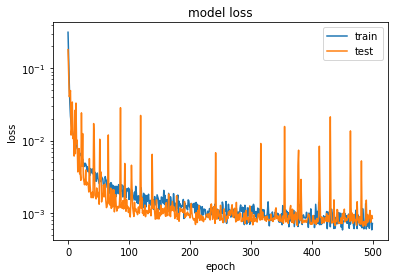

In [19]:
train_plot(history)

In [21]:
evaluate_model(model, eval_set, n, m, batch_size=32)

355/355 [==============================] - 0s 64us/step


0.0006578645796816744

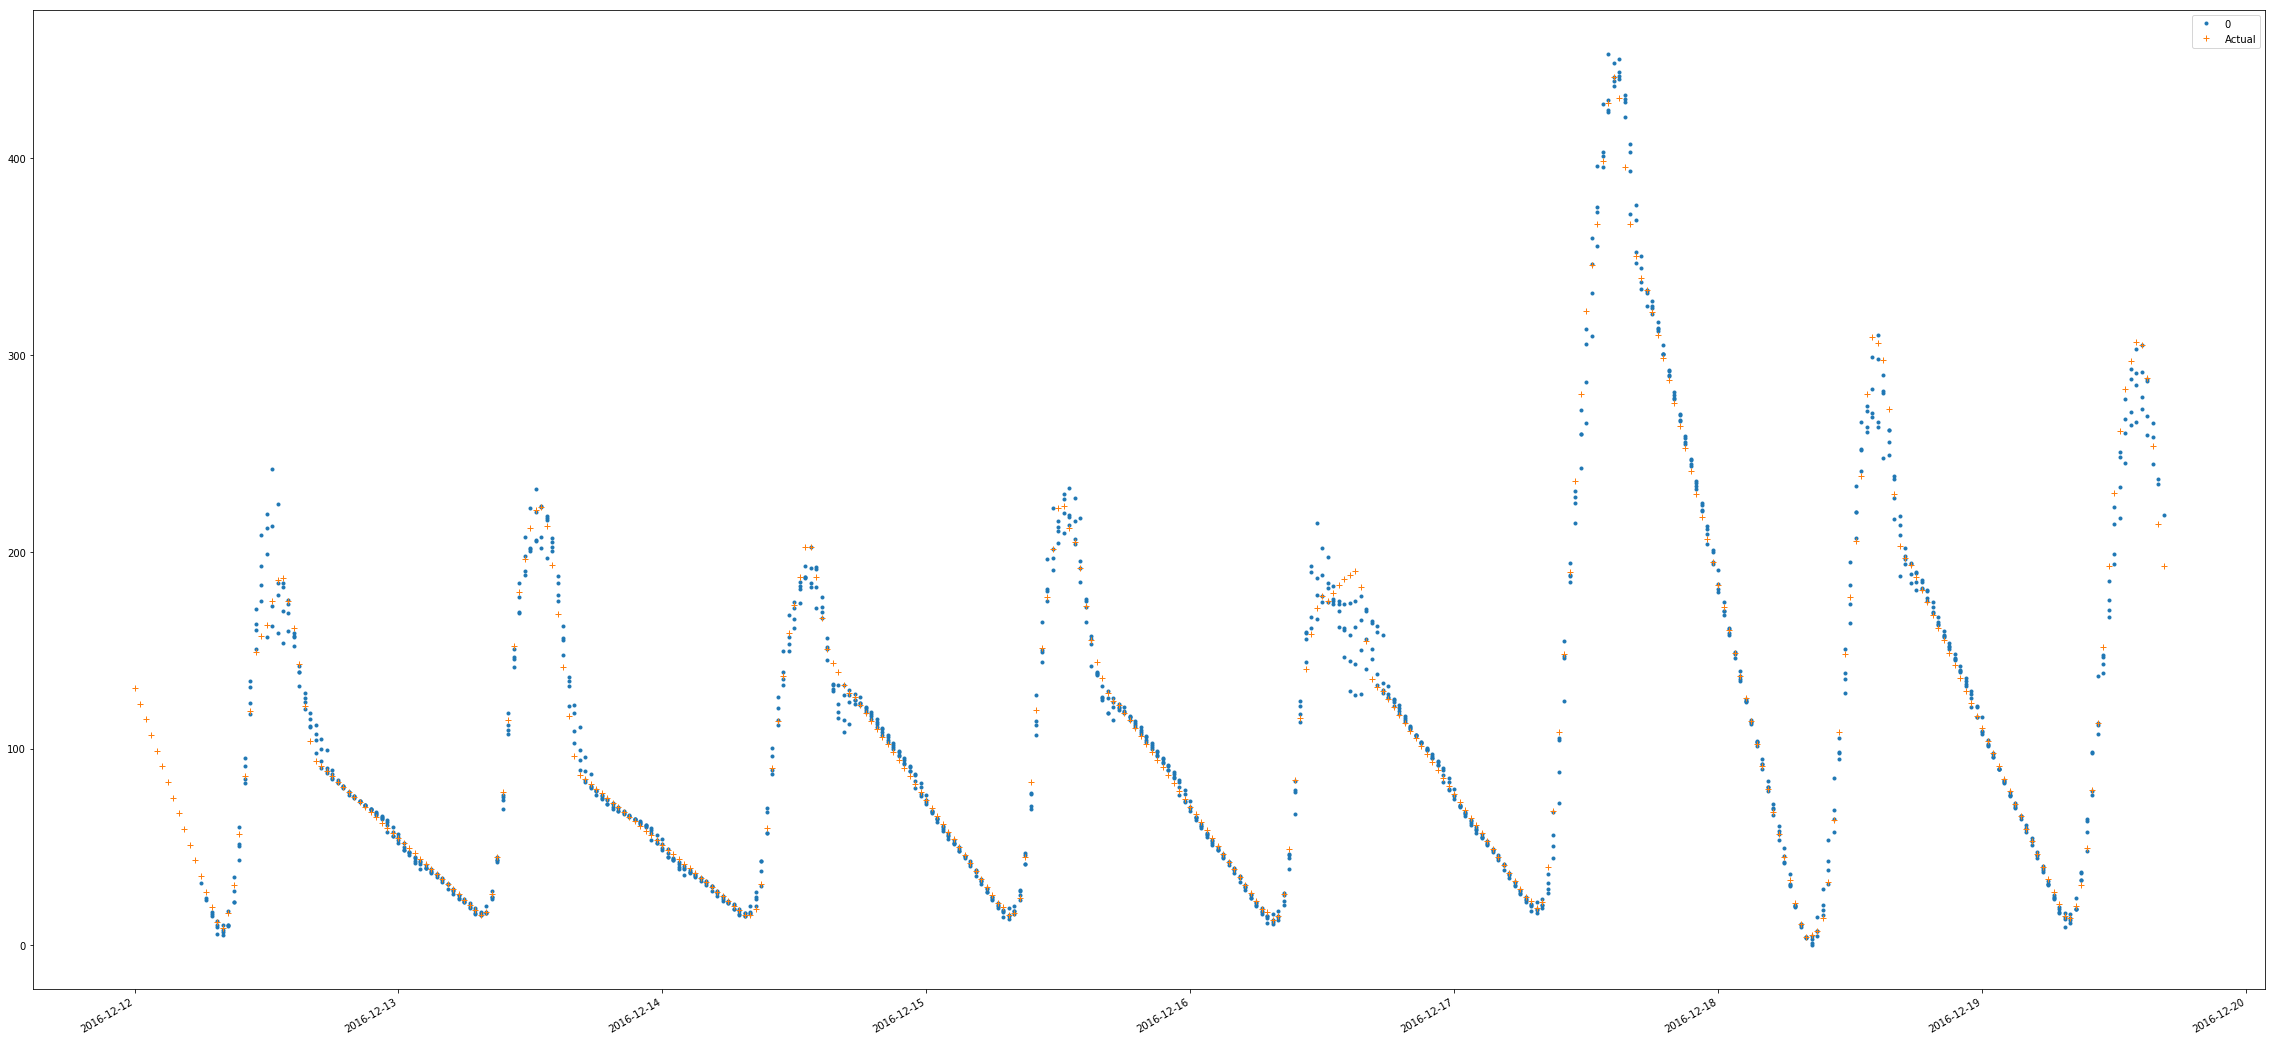

In [28]:
evaluate_model_plot(model, eval_set, n, m, lambda x: ((x + 1.0) / 2.0) * capacity)

## Does number of units matter? One LSTM Layer, 100 units

In [33]:
%%time
data = dataset['BHMBCCMKT01']
n, m = 12, 4  # Predict 2 hour ahead using 6 hours worth of past data
train_set, eval_set, capacity = split_by_week(data, validation_size=2)
model, history = train_model(train_set, eval_set, n, m,
                    num_lstm_layers=1,
                    hidden_size=100,
                    batch_size=32,
                    epochs=500)

Train on 3282 samples, validate on 355 samples
Epoch 1/500
3282/3282 [==============================] - 1s 345us/step - loss: 0.2785 - val_loss: 0.1642
Epoch 2/500
3282/3282 [==============================] - 1s 159us/step - loss: 0.1172 - val_loss: 0.0686
Epoch 3/500
3282/3282 [==============================] - 1s 168us/step - loss: 0.0467 - val_loss: 0.0324
Epoch 4/500
3282/3282 [==============================] - 1s 172us/step - loss: 0.0294 - val_loss: 0.0210
Epoch 5/500
3282/3282 [==============================] - 1s 162us/step - loss: 0.0232 - val_loss: 0.0213
Epoch 6/500
3282/3282 [==============================] - 1s 155us/step - loss: 0.0199 - val_loss: 0.0222
Epoch 7/500
3282/3282 [==============================] - 0s 151us/step - loss: 0.0173 - val_loss: 0.0104
Epoch 8/500
3282/3282 [==============================] - 1s 174us/step - loss: 0.0152 - val_loss: 0.0158
Epoch 9/500
3282/3282 [==============================] - 1s 166us/step - loss: 0.0145 - val_loss: 0.0090
Epoch 10

Epoch 78/500
3282/3282 [==============================] - 1s 165us/step - loss: 0.0026 - val_loss: 0.0027
Epoch 79/500
3282/3282 [==============================] - 1s 169us/step - loss: 0.0026 - val_loss: 0.0017
Epoch 80/500
3282/3282 [==============================] - 1s 164us/step - loss: 0.0022 - val_loss: 0.0012
Epoch 81/500
3282/3282 [==============================] - 1s 160us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 82/500
3282/3282 [==============================] - 1s 155us/step - loss: 0.0029 - val_loss: 0.0016
Epoch 83/500
3282/3282 [==============================] - 1s 160us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 84/500
3282/3282 [==============================] - 1s 166us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 85/500
3282/3282 [==============================] - 1s 160us/step - loss: 0.0027 - val_loss: 0.0011
Epoch 86/500
3282/3282 [==============================] - 1s 164us/step - loss: 0.0021 - val_loss: 0.0010
Epoch 87/500
3282/3282 [======================

Epoch 154/500
3282/3282 [==============================] - 1s 170us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 155/500
3282/3282 [==============================] - 1s 165us/step - loss: 0.0011 - val_loss: 9.4164e-04
Epoch 156/500
3282/3282 [==============================] - 1s 164us/step - loss: 0.0017 - val_loss: 9.2087e-04
Epoch 157/500
3282/3282 [==============================] - 1s 165us/step - loss: 0.0011 - val_loss: 8.8695e-04
Epoch 158/500
3282/3282 [==============================] - 1s 164us/step - loss: 0.0019 - val_loss: 0.0011
Epoch 159/500
3282/3282 [==============================] - 1s 171us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 160/500
3282/3282 [==============================] - 1s 161us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 161/500
3282/3282 [==============================] - 0s 148us/step - loss: 0.0016 - val_loss: 0.0010
Epoch 162/500
3282/3282 [==============================] - 1s 171us/step - loss: 0.0013 - val_loss: 0.0022
Epoch 163/500
3282/3282 [

Epoch 229/500
3282/3282 [==============================] - 1s 169us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 230/500
3282/3282 [==============================] - 1s 165us/step - loss: 0.0010 - val_loss: 9.6402e-04
Epoch 231/500
3282/3282 [==============================] - 1s 168us/step - loss: 9.0746e-04 - val_loss: 0.0012
Epoch 232/500
3282/3282 [==============================] - 1s 168us/step - loss: 0.0014 - val_loss: 9.9492e-04
Epoch 233/500
3282/3282 [==============================] - 1s 165us/step - loss: 9.9823e-04 - val_loss: 0.0011
Epoch 234/500
3282/3282 [==============================] - 1s 164us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 235/500
3282/3282 [==============================] - 1s 170us/step - loss: 0.0012 - val_loss: 8.1923e-04
Epoch 236/500
3282/3282 [==============================] - 1s 167us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 237/500
3282/3282 [==============================] - 1s 166us/step - loss: 0.0014 - val_loss: 9.7371e-04
Epoch 238/500

3282/3282 [==============================] - 1s 164us/step - loss: 0.0010 - val_loss: 8.3539e-04
Epoch 303/500
3282/3282 [==============================] - 0s 141us/step - loss: 0.0010 - val_loss: 9.8232e-04
Epoch 304/500
3282/3282 [==============================] - 1s 163us/step - loss: 9.8027e-04 - val_loss: 8.3066e-04
Epoch 305/500
3282/3282 [==============================] - 1s 171us/step - loss: 7.4219e-04 - val_loss: 9.2315e-04
Epoch 306/500
3282/3282 [==============================] - 1s 174us/step - loss: 0.0011 - val_loss: 9.4311e-04
Epoch 307/500
3282/3282 [==============================] - 1s 161us/step - loss: 0.0011 - val_loss: 9.6144e-04
Epoch 308/500
3282/3282 [==============================] - 1s 165us/step - loss: 9.0962e-04 - val_loss: 7.9498e-04
Epoch 309/500
3282/3282 [==============================] - 1s 158us/step - loss: 0.0012 - val_loss: 0.0039
Epoch 310/500
3282/3282 [==============================] - 1s 170us/step - loss: 0.0013 - val_loss: 0.0029
Epoch 311/5

3282/3282 [==============================] - 1s 168us/step - loss: 8.2838e-04 - val_loss: 9.3884e-04
Epoch 376/500
3282/3282 [==============================] - 1s 171us/step - loss: 0.0015 - val_loss: 9.8057e-04
Epoch 377/500
3282/3282 [==============================] - 1s 176us/step - loss: 8.0898e-04 - val_loss: 9.0214e-04
Epoch 378/500
3282/3282 [==============================] - 1s 163us/step - loss: 8.8457e-04 - val_loss: 0.0010
Epoch 379/500
3282/3282 [==============================] - 1s 169us/step - loss: 7.3183e-04 - val_loss: 8.4215e-04
Epoch 380/500
3282/3282 [==============================] - 1s 173us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 381/500
3282/3282 [==============================] - 1s 169us/step - loss: 9.9251e-04 - val_loss: 8.8290e-04
Epoch 382/500
3282/3282 [==============================] - 1s 161us/step - loss: 8.3951e-04 - val_loss: 0.0010
Epoch 383/500
3282/3282 [==============================] - 1s 165us/step - loss: 8.2101e-04 - val_loss: 0.0019
Epo

3282/3282 [==============================] - 1s 170us/step - loss: 9.3790e-04 - val_loss: 8.8825e-04
Epoch 448/500
3282/3282 [==============================] - 1s 170us/step - loss: 6.9380e-04 - val_loss: 0.0010
Epoch 449/500
3282/3282 [==============================] - 0s 141us/step - loss: 8.2271e-04 - val_loss: 9.1767e-04
Epoch 450/500
3282/3282 [==============================] - 0s 133us/step - loss: 8.9951e-04 - val_loss: 8.8105e-04
Epoch 451/500
3282/3282 [==============================] - 1s 159us/step - loss: 7.1339e-04 - val_loss: 0.0012
Epoch 452/500
3282/3282 [==============================] - 1s 160us/step - loss: 6.6468e-04 - val_loss: 0.0012
Epoch 453/500
3282/3282 [==============================] - 1s 167us/step - loss: 9.5741e-04 - val_loss: 9.4640e-04
Epoch 454/500
3282/3282 [==============================] - 1s 162us/step - loss: 7.6252e-04 - val_loss: 0.0011
Epoch 455/500
3282/3282 [==============================] - 1s 164us/step - loss: 9.2920e-04 - val_loss: 9.9305

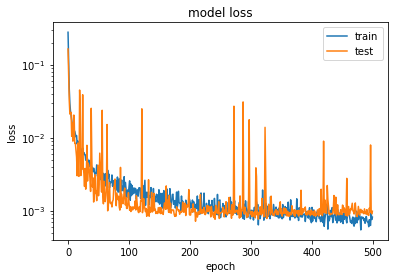

In [34]:
train_plot(history)

In [36]:
evaluate_model(model, eval_set, n, m, batch_size=32)

355/355 [==============================] - 0s 63us/step


0.0007145445059302827

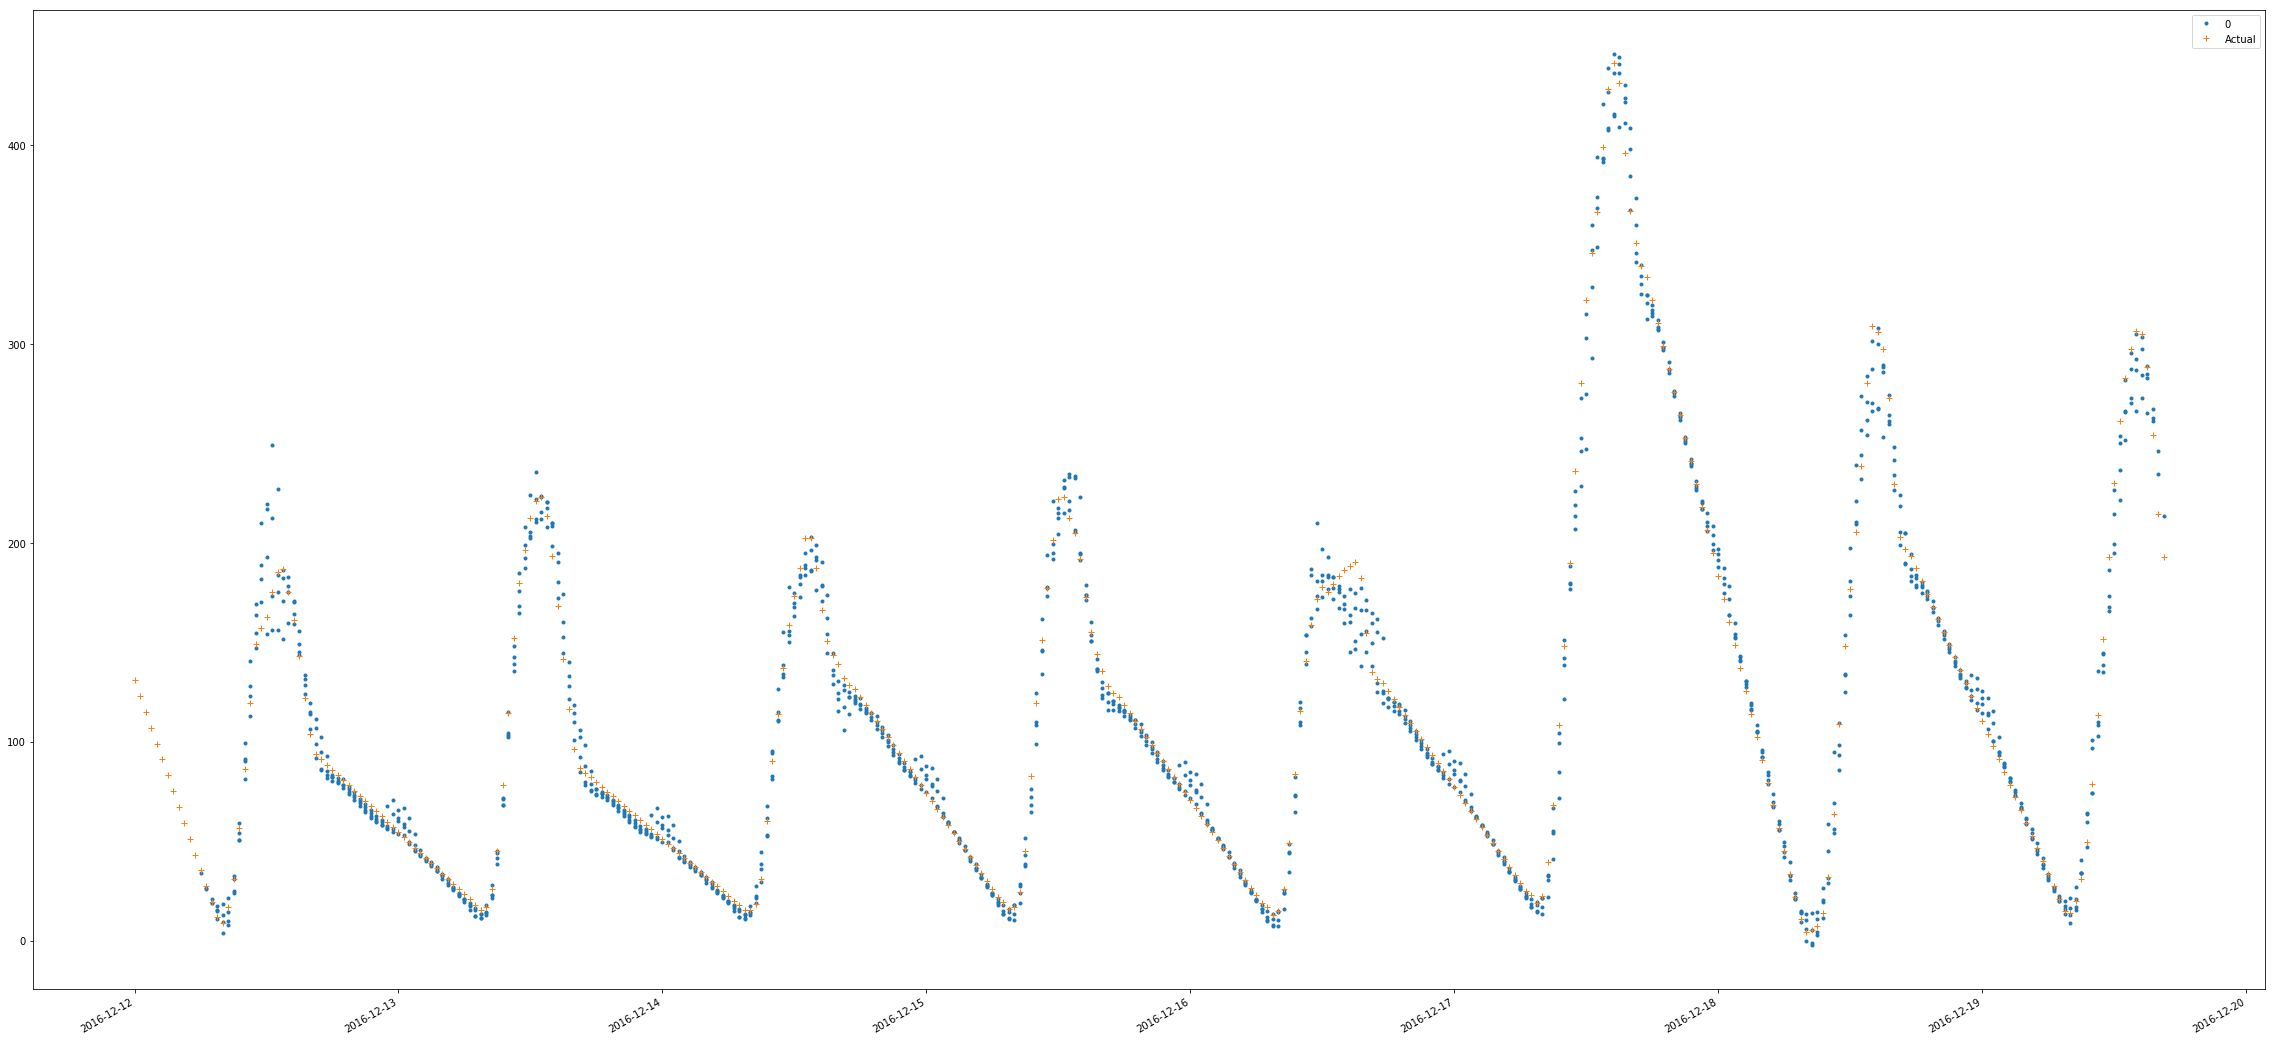

In [35]:
evaluate_model_plot(model, eval_set, n, m, lambda x: ((x + 1.0) / 2.0) * capacity)

## How about stacking additional layers? Two LSTM layers, 40 units

In [38]:
%%time
data = dataset['BHMBCCMKT01']
n, m = 12, 4  # Predict 2 hour ahead using 6 hours worth of past data
train_set, eval_set, capacity = split_by_week(data, validation_size=2)
model, history = train_model(train_set, eval_set, n, m,
                    num_lstm_layers=2,
                    hidden_size=40,
                    batch_size=32,
                    epochs=500)

Train on 3282 samples, validate on 355 samples
Epoch 1/500
3282/3282 [==============================] - 2s 530us/step - loss: 0.2948 - val_loss: 0.1952
Epoch 2/500
3282/3282 [==============================] - 1s 243us/step - loss: 0.1484 - val_loss: 0.0745
Epoch 3/500
3282/3282 [==============================] - 1s 238us/step - loss: 0.0473 - val_loss: 0.0286
Epoch 4/500
3282/3282 [==============================] - 1s 244us/step - loss: 0.0269 - val_loss: 0.0301
Epoch 5/500
3282/3282 [==============================] - 1s 218us/step - loss: 0.0215 - val_loss: 0.0158
Epoch 6/500
3282/3282 [==============================] - 1s 222us/step - loss: 0.0179 - val_loss: 0.0138
Epoch 7/500
3282/3282 [==============================] - 1s 223us/step - loss: 0.0168 - val_loss: 0.0122
Epoch 8/500
3282/3282 [==============================] - 1s 237us/step - loss: 0.0149 - val_loss: 0.0149
Epoch 9/500
3282/3282 [==============================] - 1s 223us/step - loss: 0.0133 - val_loss: 0.0112
Epoch 10

Epoch 78/500
3282/3282 [==============================] - 1s 232us/step - loss: 0.0018 - val_loss: 0.0246
Epoch 79/500
3282/3282 [==============================] - 1s 244us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 80/500
3282/3282 [==============================] - 1s 249us/step - loss: 0.0024 - val_loss: 0.0130
Epoch 81/500
3282/3282 [==============================] - 1s 254us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 82/500
3282/3282 [==============================] - 1s 240us/step - loss: 0.0027 - val_loss: 0.0032
Epoch 83/500
3282/3282 [==============================] - 1s 247us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 84/500
3282/3282 [==============================] - 1s 248us/step - loss: 0.0016 - val_loss: 0.0024
Epoch 85/500
3282/3282 [==============================] - 1s 235us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 86/500
3282/3282 [==============================] - 1s 221us/step - loss: 0.0024 - val_loss: 0.0014
Epoch 87/500
3282/3282 [======================

3282/3282 [==============================] - 1s 224us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 155/500
3282/3282 [==============================] - 1s 248us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 156/500
3282/3282 [==============================] - 1s 242us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 157/500
3282/3282 [==============================] - 1s 237us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 158/500
3282/3282 [==============================] - 1s 245us/step - loss: 0.0018 - val_loss: 0.0010
Epoch 159/500
3282/3282 [==============================] - 1s 226us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 160/500
3282/3282 [==============================] - 1s 237us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 161/500
3282/3282 [==============================] - 1s 229us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 162/500
3282/3282 [==============================] - 1s 205us/step - loss: 0.0017 - val_loss: 8.7994e-04
Epoch 163/500
3282/3282 [======================

3282/3282 [==============================] - 1s 208us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 231/500
3282/3282 [==============================] - 1s 238us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 232/500
3282/3282 [==============================] - 1s 232us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 233/500
3282/3282 [==============================] - 1s 232us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 234/500
3282/3282 [==============================] - 1s 222us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 235/500
3282/3282 [==============================] - 1s 244us/step - loss: 0.0012 - val_loss: 8.0248e-04
Epoch 236/500
3282/3282 [==============================] - 1s 245us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 237/500
3282/3282 [==============================] - 1s 238us/step - loss: 0.0021 - val_loss: 0.0012
Epoch 238/500
3282/3282 [==============================] - 1s 245us/step - loss: 7.9551e-04 - val_loss: 0.0013
Epoch 239/500
3282/3282 [==================

3282/3282 [==============================] - 1s 215us/step - loss: 7.5895e-04 - val_loss: 8.4409e-04
Epoch 305/500
3282/3282 [==============================] - 1s 221us/step - loss: 0.0012 - val_loss: 0.0031
Epoch 306/500
3282/3282 [==============================] - 1s 207us/step - loss: 0.0011 - val_loss: 8.8953e-04
Epoch 307/500
3282/3282 [==============================] - 1s 200us/step - loss: 7.6808e-04 - val_loss: 8.9090e-04
Epoch 308/500
3282/3282 [==============================] - 1s 194us/step - loss: 9.9945e-04 - val_loss: 0.0013
Epoch 309/500
3282/3282 [==============================] - 1s 237us/step - loss: 9.5976e-04 - val_loss: 0.0011
Epoch 310/500
3282/3282 [==============================] - 1s 208us/step - loss: 9.7448e-04 - val_loss: 9.1222e-04
Epoch 311/500
3282/3282 [==============================] - 1s 225us/step - loss: 0.0011 - val_loss: 8.2980e-04
Epoch 312/500
3282/3282 [==============================] - 1s 216us/step - loss: 0.0012 - val_loss: 7.2162e-04
Epoch 3

Epoch 377/500
3282/3282 [==============================] - 1s 246us/step - loss: 8.8067e-04 - val_loss: 8.1101e-04
Epoch 378/500
3282/3282 [==============================] - 1s 236us/step - loss: 8.7485e-04 - val_loss: 8.5241e-04
Epoch 379/500
3282/3282 [==============================] - 1s 241us/step - loss: 8.4590e-04 - val_loss: 8.5022e-04
Epoch 380/500
3282/3282 [==============================] - 1s 218us/step - loss: 6.7994e-04 - val_loss: 0.0083
Epoch 381/500
3282/3282 [==============================] - 1s 249us/step - loss: 6.7083e-04 - val_loss: 7.6011e-04
Epoch 382/500
3282/3282 [==============================] - 1s 234us/step - loss: 0.0010 - val_loss: 8.3113e-04
Epoch 383/500
3282/3282 [==============================] - 1s 239us/step - loss: 7.0532e-04 - val_loss: 9.2349e-04
Epoch 384/500
3282/3282 [==============================] - 1s 241us/step - loss: 8.9198e-04 - val_loss: 7.4655e-04
Epoch 385/500
3282/3282 [==============================] - 1s 242us/step - loss: 0.0010 

3282/3282 [==============================] - 1s 240us/step - loss: 7.1524e-04 - val_loss: 7.7768e-04
Epoch 450/500
3282/3282 [==============================] - 1s 233us/step - loss: 8.6913e-04 - val_loss: 8.4340e-04
Epoch 451/500
3282/3282 [==============================] - 1s 244us/step - loss: 5.8468e-04 - val_loss: 0.0012
Epoch 452/500
3282/3282 [==============================] - 1s 230us/step - loss: 7.4916e-04 - val_loss: 8.5352e-04
Epoch 453/500
3282/3282 [==============================] - 1s 249us/step - loss: 6.1219e-04 - val_loss: 7.5354e-04
Epoch 454/500
3282/3282 [==============================] - 1s 250us/step - loss: 7.7596e-04 - val_loss: 8.1478e-04
Epoch 455/500
3282/3282 [==============================] - 1s 248us/step - loss: 8.7383e-04 - val_loss: 0.0031
Epoch 456/500
3282/3282 [==============================] - 1s 249us/step - loss: 6.1981e-04 - val_loss: 8.3779e-04
Epoch 457/500
3282/3282 [==============================] - 1s 239us/step - loss: 7.0407e-04 - val_loss

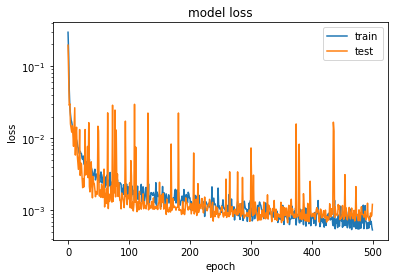

In [39]:
train_plot(history)

In [40]:
evaluate_model(model, eval_set, n, m, batch_size=32)

355/355 [==============================] - 0s 92us/step


0.0006756687523718451

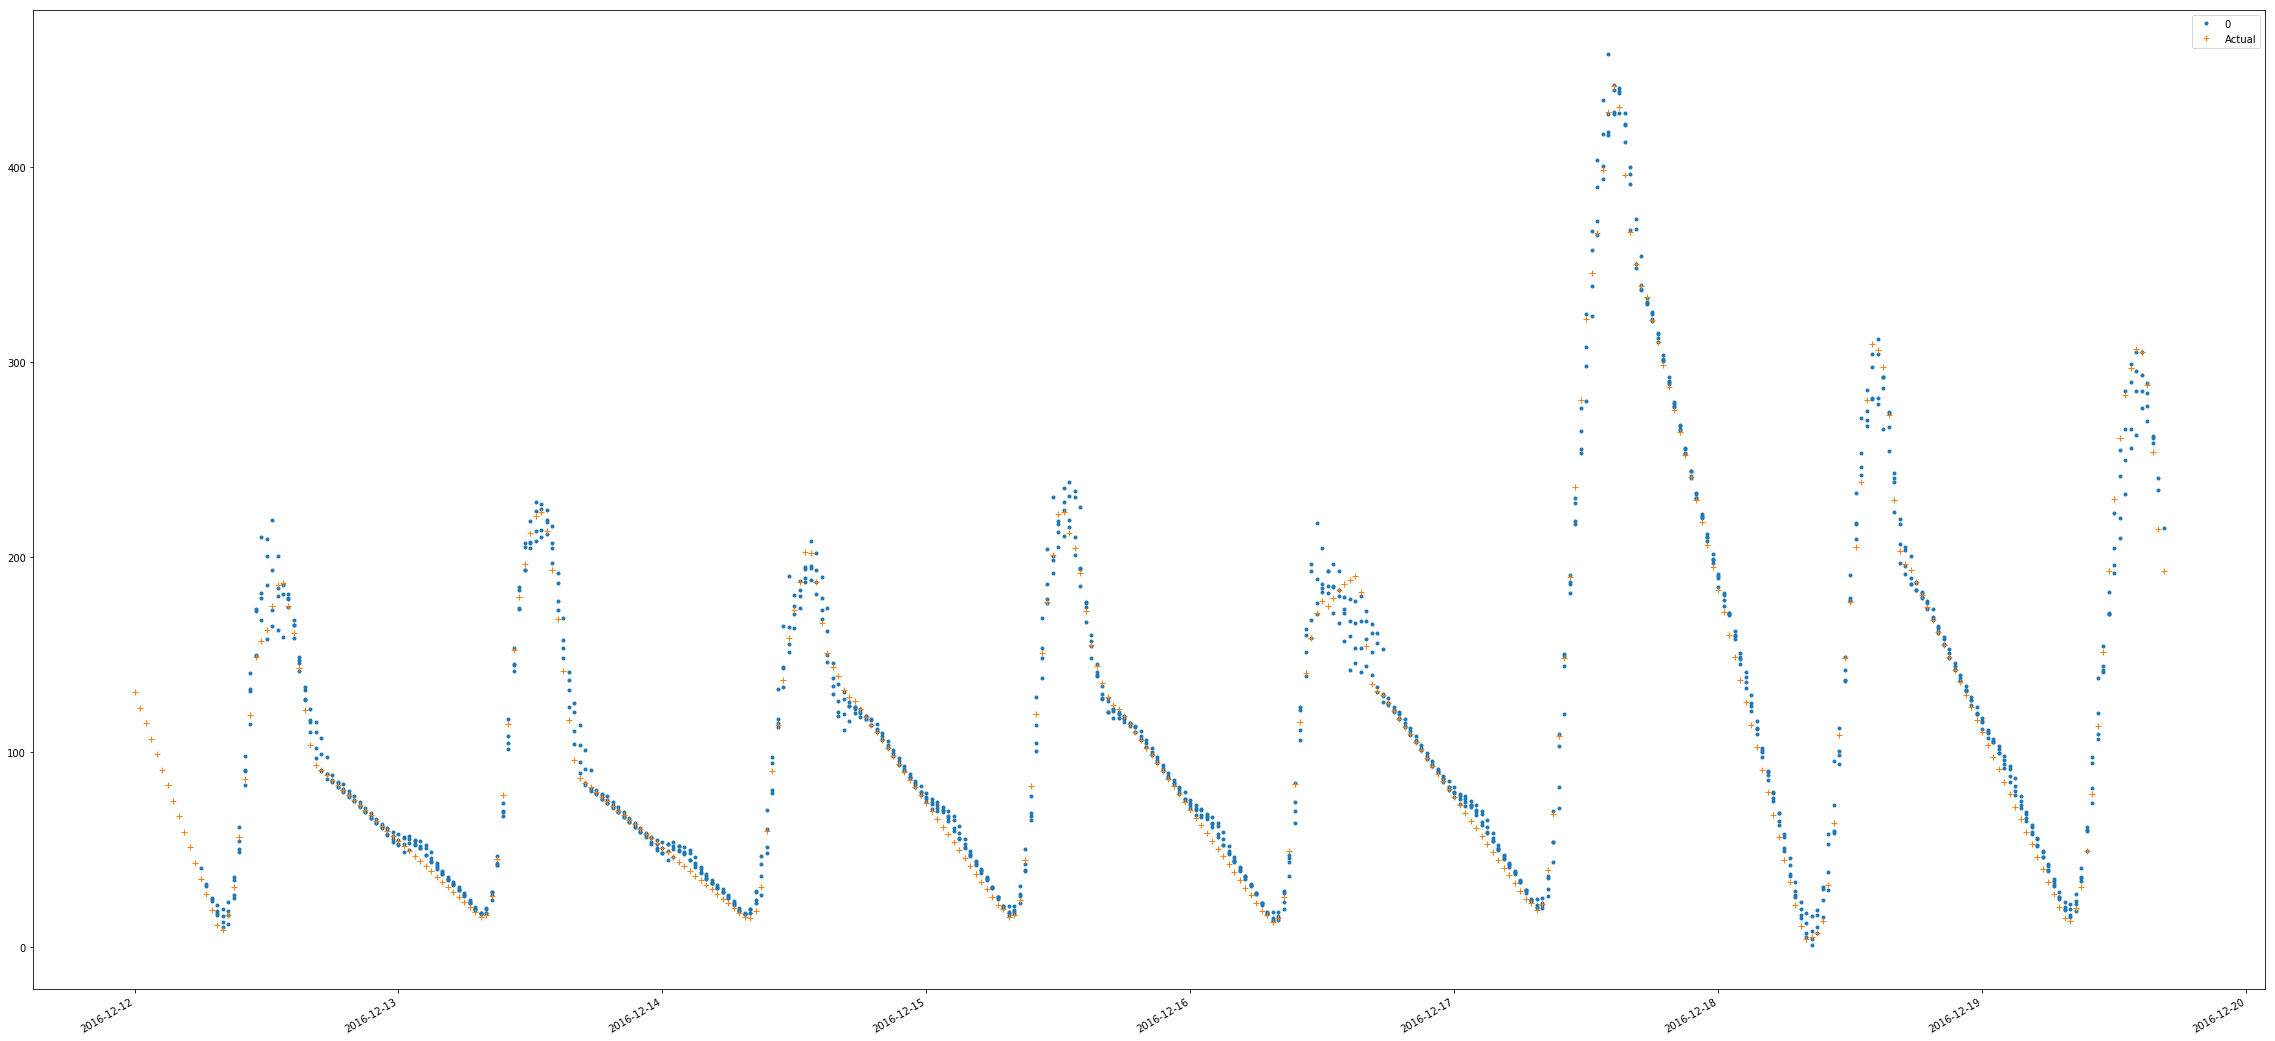

In [41]:
evaluate_model_plot(model, eval_set, n, m, lambda x: ((x + 1.0) / 2.0) * capacity)

## How about more data?

In [42]:
%%time
data = dataset['BHMBCCMKT01']
n, m = 16, 4  # Predict 2 hour ahead using 8 hours worth of past data
train_set, eval_set, capacity = split_by_week(data, validation_size=2)
model, history = train_model(train_set, eval_set, n, m,
                    num_lstm_layers=1,
                    hidden_size=40,
                    batch_size=32,
                    epochs=500)

Train on 3278 samples, validate on 351 samples
Epoch 1/500
3278/3278 [==============================] - 2s 512us/step - loss: 0.2605 - val_loss: 0.1683
Epoch 2/500
3278/3278 [==============================] - 1s 167us/step - loss: 0.1119 - val_loss: 0.0581
Epoch 3/500
3278/3278 [==============================] - 1s 176us/step - loss: 0.0414 - val_loss: 0.0313
Epoch 4/500
3278/3278 [==============================] - 1s 175us/step - loss: 0.0272 - val_loss: 0.0284
Epoch 5/500
3278/3278 [==============================] - 1s 175us/step - loss: 0.0214 - val_loss: 0.0157
Epoch 6/500
3278/3278 [==============================] - 1s 164us/step - loss: 0.0184 - val_loss: 0.0153
Epoch 7/500
3278/3278 [==============================] - 1s 172us/step - loss: 0.0141 - val_loss: 0.0129
Epoch 8/500
3278/3278 [==============================] - 1s 168us/step - loss: 0.0135 - val_loss: 0.0082
Epoch 9/500
3278/3278 [==============================] - 1s 163us/step - loss: 0.0116 - val_loss: 0.0082
Epoch 10

Epoch 78/500
3278/3278 [==============================] - 0s 142us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 79/500
3278/3278 [==============================] - 0s 146us/step - loss: 0.0025 - val_loss: 0.0018
Epoch 80/500
3278/3278 [==============================] - 0s 143us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 81/500
3278/3278 [==============================] - 0s 150us/step - loss: 0.0019 - val_loss: 0.0066
Epoch 82/500
3278/3278 [==============================] - 1s 164us/step - loss: 0.0023 - val_loss: 0.0032
Epoch 83/500
3278/3278 [==============================] - 1s 158us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 84/500
3278/3278 [==============================] - 0s 135us/step - loss: 0.0021 - val_loss: 0.0018
Epoch 85/500
3278/3278 [==============================] - 0s 124us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 86/500
3278/3278 [==============================] - 1s 163us/step - loss: 0.0026 - val_loss: 0.0012
Epoch 87/500
3278/3278 [======================

3278/3278 [==============================] - 0s 146us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 155/500
3278/3278 [==============================] - 0s 150us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 156/500
3278/3278 [==============================] - 0s 145us/step - loss: 0.0011 - val_loss: 9.9301e-04
Epoch 157/500
3278/3278 [==============================] - 1s 159us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 158/500
3278/3278 [==============================] - 1s 155us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 159/500
3278/3278 [==============================] - 1s 162us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 160/500
3278/3278 [==============================] - 0s 149us/step - loss: 0.0012 - val_loss: 0.0032
Epoch 161/500
3278/3278 [==============================] - 0s 141us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 162/500
3278/3278 [==============================] - 0s 152us/step - loss: 0.0013 - val_loss: 8.5915e-04
Epoch 163/500
3278/3278 [==================

Epoch 229/500
3278/3278 [==============================] - 0s 134us/step - loss: 9.1224e-04 - val_loss: 8.9128e-04
Epoch 230/500
3278/3278 [==============================] - 0s 134us/step - loss: 9.7682e-04 - val_loss: 9.9307e-04
Epoch 231/500
3278/3278 [==============================] - 0s 132us/step - loss: 0.0011 - val_loss: 8.8054e-04
Epoch 232/500
3278/3278 [==============================] - 0s 125us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 233/500
3278/3278 [==============================] - 0s 134us/step - loss: 0.0011 - val_loss: 8.4959e-04
Epoch 234/500
3278/3278 [==============================] - 0s 125us/step - loss: 9.7330e-04 - val_loss: 0.0011
Epoch 235/500
3278/3278 [==============================] - 0s 129us/step - loss: 0.0010 - val_loss: 9.3803e-04
Epoch 236/500
3278/3278 [==============================] - 0s 141us/step - loss: 8.7996e-04 - val_loss: 0.0011
Epoch 237/500
3278/3278 [==============================] - 0s 147us/step - loss: 0.0011 - val_loss: 8.5436e-

3278/3278 [==============================] - 1s 163us/step - loss: 8.2783e-04 - val_loss: 9.3530e-04
Epoch 303/500
3278/3278 [==============================] - 1s 153us/step - loss: 9.8431e-04 - val_loss: 0.0013
Epoch 304/500
3278/3278 [==============================] - 1s 171us/step - loss: 9.1705e-04 - val_loss: 8.8513e-04
Epoch 305/500
3278/3278 [==============================] - 1s 174us/step - loss: 8.7617e-04 - val_loss: 9.9926e-04
Epoch 306/500
3278/3278 [==============================] - 1s 169us/step - loss: 8.3588e-04 - val_loss: 8.9317e-04
Epoch 307/500
3278/3278 [==============================] - 1s 158us/step - loss: 8.2867e-04 - val_loss: 8.8703e-04
Epoch 308/500
3278/3278 [==============================] - 1s 164us/step - loss: 9.3245e-04 - val_loss: 0.0011
Epoch 309/500
3278/3278 [==============================] - 1s 156us/step - loss: 7.1228e-04 - val_loss: 7.8462e-04
Epoch 310/500
3278/3278 [==============================] - 1s 167us/step - loss: 8.1581e-04 - val_loss

3278/3278 [==============================] - 1s 160us/step - loss: 7.0570e-04 - val_loss: 9.0315e-04
Epoch 375/500
3278/3278 [==============================] - 1s 168us/step - loss: 7.4691e-04 - val_loss: 9.7206e-04
Epoch 376/500
3278/3278 [==============================] - 1s 167us/step - loss: 6.6370e-04 - val_loss: 0.0047
Epoch 377/500
3278/3278 [==============================] - 1s 169us/step - loss: 6.8506e-04 - val_loss: 0.0013
Epoch 378/500
3278/3278 [==============================] - 1s 169us/step - loss: 7.6475e-04 - val_loss: 8.5571e-04
Epoch 379/500
3278/3278 [==============================] - 0s 137us/step - loss: 6.5952e-04 - val_loss: 7.3103e-04
Epoch 380/500
3278/3278 [==============================] - 1s 168us/step - loss: 7.3496e-04 - val_loss: 8.5384e-04
Epoch 381/500
3278/3278 [==============================] - 1s 154us/step - loss: 6.5841e-04 - val_loss: 0.0011
Epoch 382/500
3278/3278 [==============================] - 1s 159us/step - loss: 6.6369e-04 - val_loss: 0.

3278/3278 [==============================] - 0s 131us/step - loss: 6.3593e-04 - val_loss: 9.0007e-04
Epoch 447/500
3278/3278 [==============================] - 1s 158us/step - loss: 6.0075e-04 - val_loss: 0.0011
Epoch 448/500
3278/3278 [==============================] - 1s 171us/step - loss: 7.0095e-04 - val_loss: 0.0013
Epoch 449/500
3278/3278 [==============================] - 0s 152us/step - loss: 6.6951e-04 - val_loss: 0.0011
Epoch 450/500
3278/3278 [==============================] - 1s 165us/step - loss: 6.7435e-04 - val_loss: 7.0467e-04
Epoch 451/500
3278/3278 [==============================] - 1s 174us/step - loss: 5.9679e-04 - val_loss: 0.0013
Epoch 452/500
3278/3278 [==============================] - 1s 173us/step - loss: 7.0124e-04 - val_loss: 9.5821e-04
Epoch 453/500
3278/3278 [==============================] - 1s 173us/step - loss: 6.5455e-04 - val_loss: 0.0013
Epoch 454/500
3278/3278 [==============================] - 1s 159us/step - loss: 5.9615e-04 - val_loss: 9.8283e-04

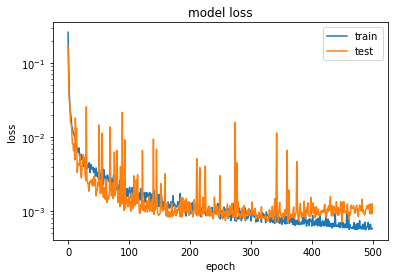

In [43]:
train_plot(history)

In [44]:
evaluate_model(model, eval_set, n, m, batch_size=32)

351/351 [==============================] - 0s 76us/step


0.0007037073574453444

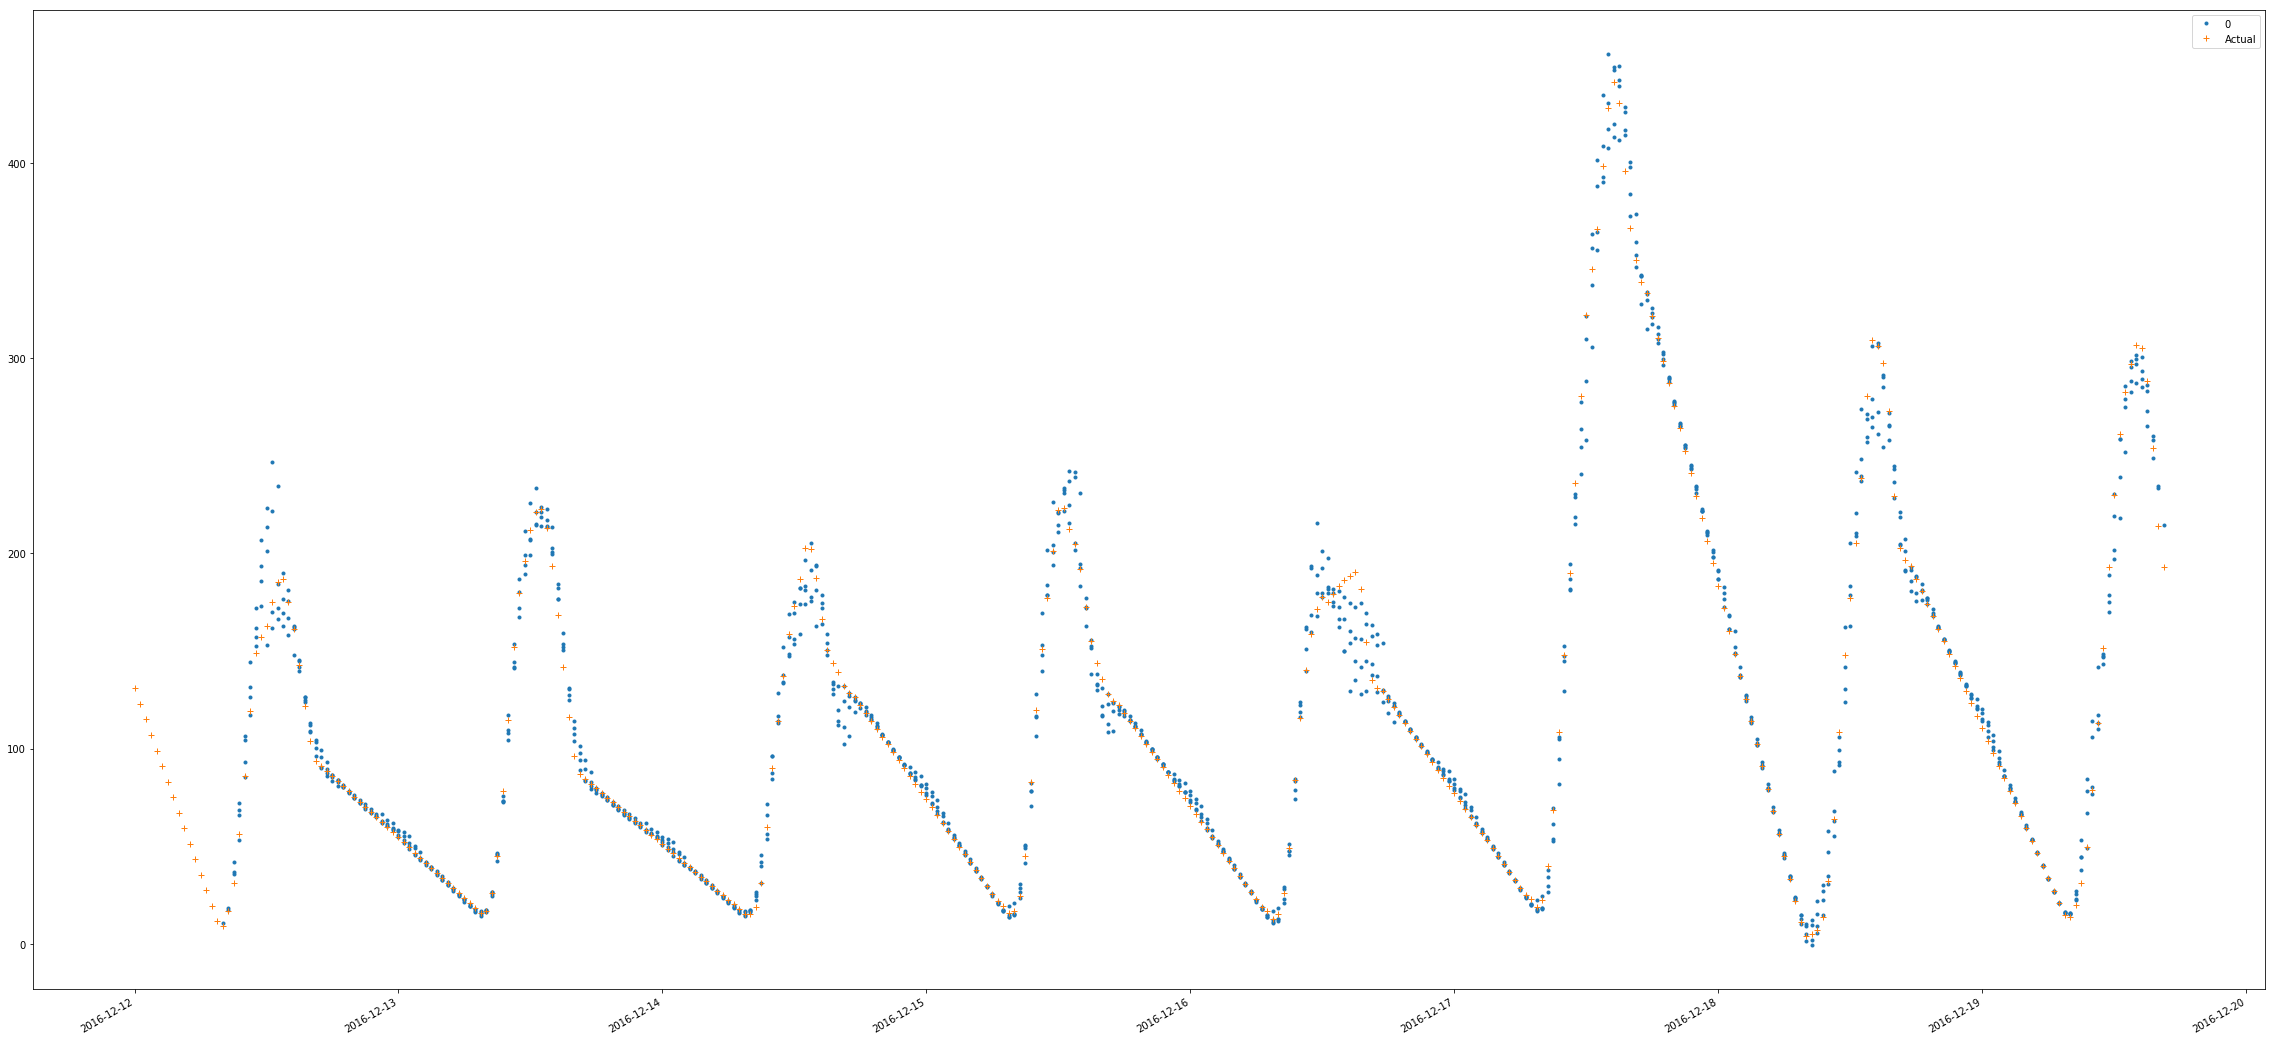

In [45]:
evaluate_model_plot(model, eval_set, n, m, lambda x: ((x + 1.0) / 2.0) * capacity)

## LESS Units?

In [46]:
%%time
data = dataset['BHMBCCMKT01']
n, m = 12, 4  # Predict 2 hour ahead using 6 hours worth of past data
train_set, eval_set, capacity = split_by_week(data, validation_size=2)
model, history = train_model(train_set, eval_set, n, m,
                    num_lstm_layers=1,
                    hidden_size=20,
                    batch_size=32,
                    epochs=500)

Train on 3282 samples, validate on 355 samples
Epoch 1/500
3282/3282 [==============================] - 2s 516us/step - loss: 0.3255 - val_loss: 0.1919
Epoch 2/500
3282/3282 [==============================] - 1s 171us/step - loss: 0.1490 - val_loss: 0.1205
Epoch 3/500
3282/3282 [==============================] - 1s 168us/step - loss: 0.1014 - val_loss: 0.0853
Epoch 4/500
3282/3282 [==============================] - 0s 151us/step - loss: 0.0803 - val_loss: 0.0693
Epoch 5/500
3282/3282 [==============================] - 1s 152us/step - loss: 0.0570 - val_loss: 0.0420
Epoch 6/500
3282/3282 [==============================] - 0s 149us/step - loss: 0.0367 - val_loss: 0.0299
Epoch 7/500
3282/3282 [==============================] - 1s 161us/step - loss: 0.0252 - val_loss: 0.0275
Epoch 8/500
3282/3282 [==============================] - 1s 156us/step - loss: 0.0209 - val_loss: 0.0175
Epoch 9/500
3282/3282 [==============================] - 0s 147us/step - loss: 0.0183 - val_loss: 0.0153
Epoch 10

Epoch 78/500
3282/3282 [==============================] - 0s 136us/step - loss: 0.0026 - val_loss: 0.0024
Epoch 79/500
3282/3282 [==============================] - 0s 150us/step - loss: 0.0023 - val_loss: 0.0015
Epoch 80/500
3282/3282 [==============================] - 0s 141us/step - loss: 0.0023 - val_loss: 0.0017
Epoch 81/500
3282/3282 [==============================] - 1s 165us/step - loss: 0.0029 - val_loss: 0.0015
Epoch 82/500
3282/3282 [==============================] - 1s 172us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 83/500
3282/3282 [==============================] - 1s 171us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 84/500
3282/3282 [==============================] - 1s 167us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 85/500
3282/3282 [==============================] - 1s 168us/step - loss: 0.0023 - val_loss: 0.0016
Epoch 86/500
3282/3282 [==============================] - 1s 157us/step - loss: 0.0023 - val_loss: 0.0015
Epoch 87/500
3282/3282 [======================

3282/3282 [==============================] - 1s 165us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 155/500
3282/3282 [==============================] - 1s 166us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 156/500
3282/3282 [==============================] - 0s 139us/step - loss: 0.0014 - val_loss: 0.0312
Epoch 157/500
3282/3282 [==============================] - 0s 133us/step - loss: 0.0019 - val_loss: 0.0011
Epoch 158/500
3282/3282 [==============================] - 0s 146us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 159/500
3282/3282 [==============================] - 1s 173us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 160/500
3282/3282 [==============================] - 1s 160us/step - loss: 0.0019 - val_loss: 0.0011
Epoch 161/500
3282/3282 [==============================] - 1s 174us/step - loss: 0.0019 - val_loss: 0.0041
Epoch 162/500
3282/3282 [==============================] - 1s 177us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 163/500
3282/3282 [==========================

Epoch 230/500
3282/3282 [==============================] - 1s 165us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 231/500
3282/3282 [==============================] - 1s 172us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 232/500
3282/3282 [==============================] - 1s 167us/step - loss: 0.0015 - val_loss: 9.6075e-04
Epoch 233/500
3282/3282 [==============================] - 1s 168us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 234/500
3282/3282 [==============================] - 1s 169us/step - loss: 0.0013 - val_loss: 8.9790e-04
Epoch 235/500
3282/3282 [==============================] - 1s 154us/step - loss: 9.8468e-04 - val_loss: 0.0012
Epoch 236/500
3282/3282 [==============================] - 1s 157us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 237/500
3282/3282 [==============================] - 1s 160us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 238/500
3282/3282 [==============================] - 1s 160us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 239/500
3282/3282 [

Epoch 305/500
3282/3282 [==============================] - 1s 172us/step - loss: 9.8644e-04 - val_loss: 9.5061e-04
Epoch 306/500
3282/3282 [==============================] - 1s 165us/step - loss: 0.0014 - val_loss: 0.0010
Epoch 307/500
3282/3282 [==============================] - 1s 163us/step - loss: 9.6388e-04 - val_loss: 8.6998e-04
Epoch 308/500
3282/3282 [==============================] - 1s 166us/step - loss: 0.0013 - val_loss: 9.7753e-04
Epoch 309/500
3282/3282 [==============================] - 1s 168us/step - loss: 0.0010 - val_loss: 9.2780e-04
Epoch 310/500
3282/3282 [==============================] - 1s 171us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 311/500
3282/3282 [==============================] - 1s 169us/step - loss: 9.7552e-04 - val_loss: 8.5267e-04
Epoch 312/500
3282/3282 [==============================] - 1s 168us/step - loss: 9.9631e-04 - val_loss: 0.0010
Epoch 313/500
3282/3282 [==============================] - 1s 172us/step - loss: 0.0014 - val_loss: 9.2223e-

3282/3282 [==============================] - 0s 133us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 379/500
3282/3282 [==============================] - 0s 150us/step - loss: 0.0010 - val_loss: 9.0034e-04
Epoch 380/500
3282/3282 [==============================] - 1s 172us/step - loss: 9.5190e-04 - val_loss: 0.0012
Epoch 381/500
3282/3282 [==============================] - 1s 164us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 382/500
3282/3282 [==============================] - 1s 176us/step - loss: 9.5180e-04 - val_loss: 8.1531e-04
Epoch 383/500
3282/3282 [==============================] - 1s 176us/step - loss: 0.0014 - val_loss: 9.5426e-04
Epoch 384/500
3282/3282 [==============================] - 1s 167us/step - loss: 8.4682e-04 - val_loss: 0.0012
Epoch 385/500
3282/3282 [==============================] - 1s 170us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 386/500
3282/3282 [==============================] - 1s 170us/step - loss: 0.0011 - val_loss: 8.5718e-04
Epoch 387/500
3282/3282

3282/3282 [==============================] - 1s 167us/step - loss: 8.6893e-04 - val_loss: 8.0028e-04
Epoch 452/500
3282/3282 [==============================] - 1s 167us/step - loss: 0.0012 - val_loss: 8.7310e-04
Epoch 453/500
3282/3282 [==============================] - 1s 172us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 454/500
3282/3282 [==============================] - 1s 165us/step - loss: 8.4847e-04 - val_loss: 8.3068e-04
Epoch 455/500
3282/3282 [==============================] - 1s 167us/step - loss: 0.0013 - val_loss: 9.0795e-04
Epoch 456/500
3282/3282 [==============================] - 1s 169us/step - loss: 0.0011 - val_loss: 8.0716e-04
Epoch 457/500
3282/3282 [==============================] - 1s 174us/step - loss: 9.1321e-04 - val_loss: 0.0011
Epoch 458/500
3282/3282 [==============================] - 1s 161us/step - loss: 8.8505e-04 - val_loss: 0.0011
Epoch 459/500
3282/3282 [==============================] - 1s 168us/step - loss: 8.6194e-04 - val_loss: 8.8824e-04
Epoch 4

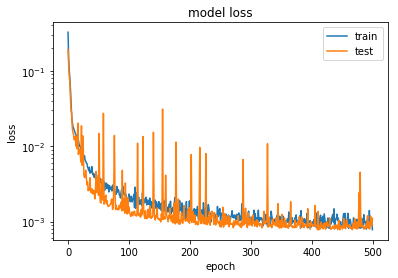

In [47]:
train_plot(history)

In [48]:
evaluate_model(model, eval_set, n, m, batch_size=32)

355/355 [==============================] - 0s 81us/step


0.0007776870418497374

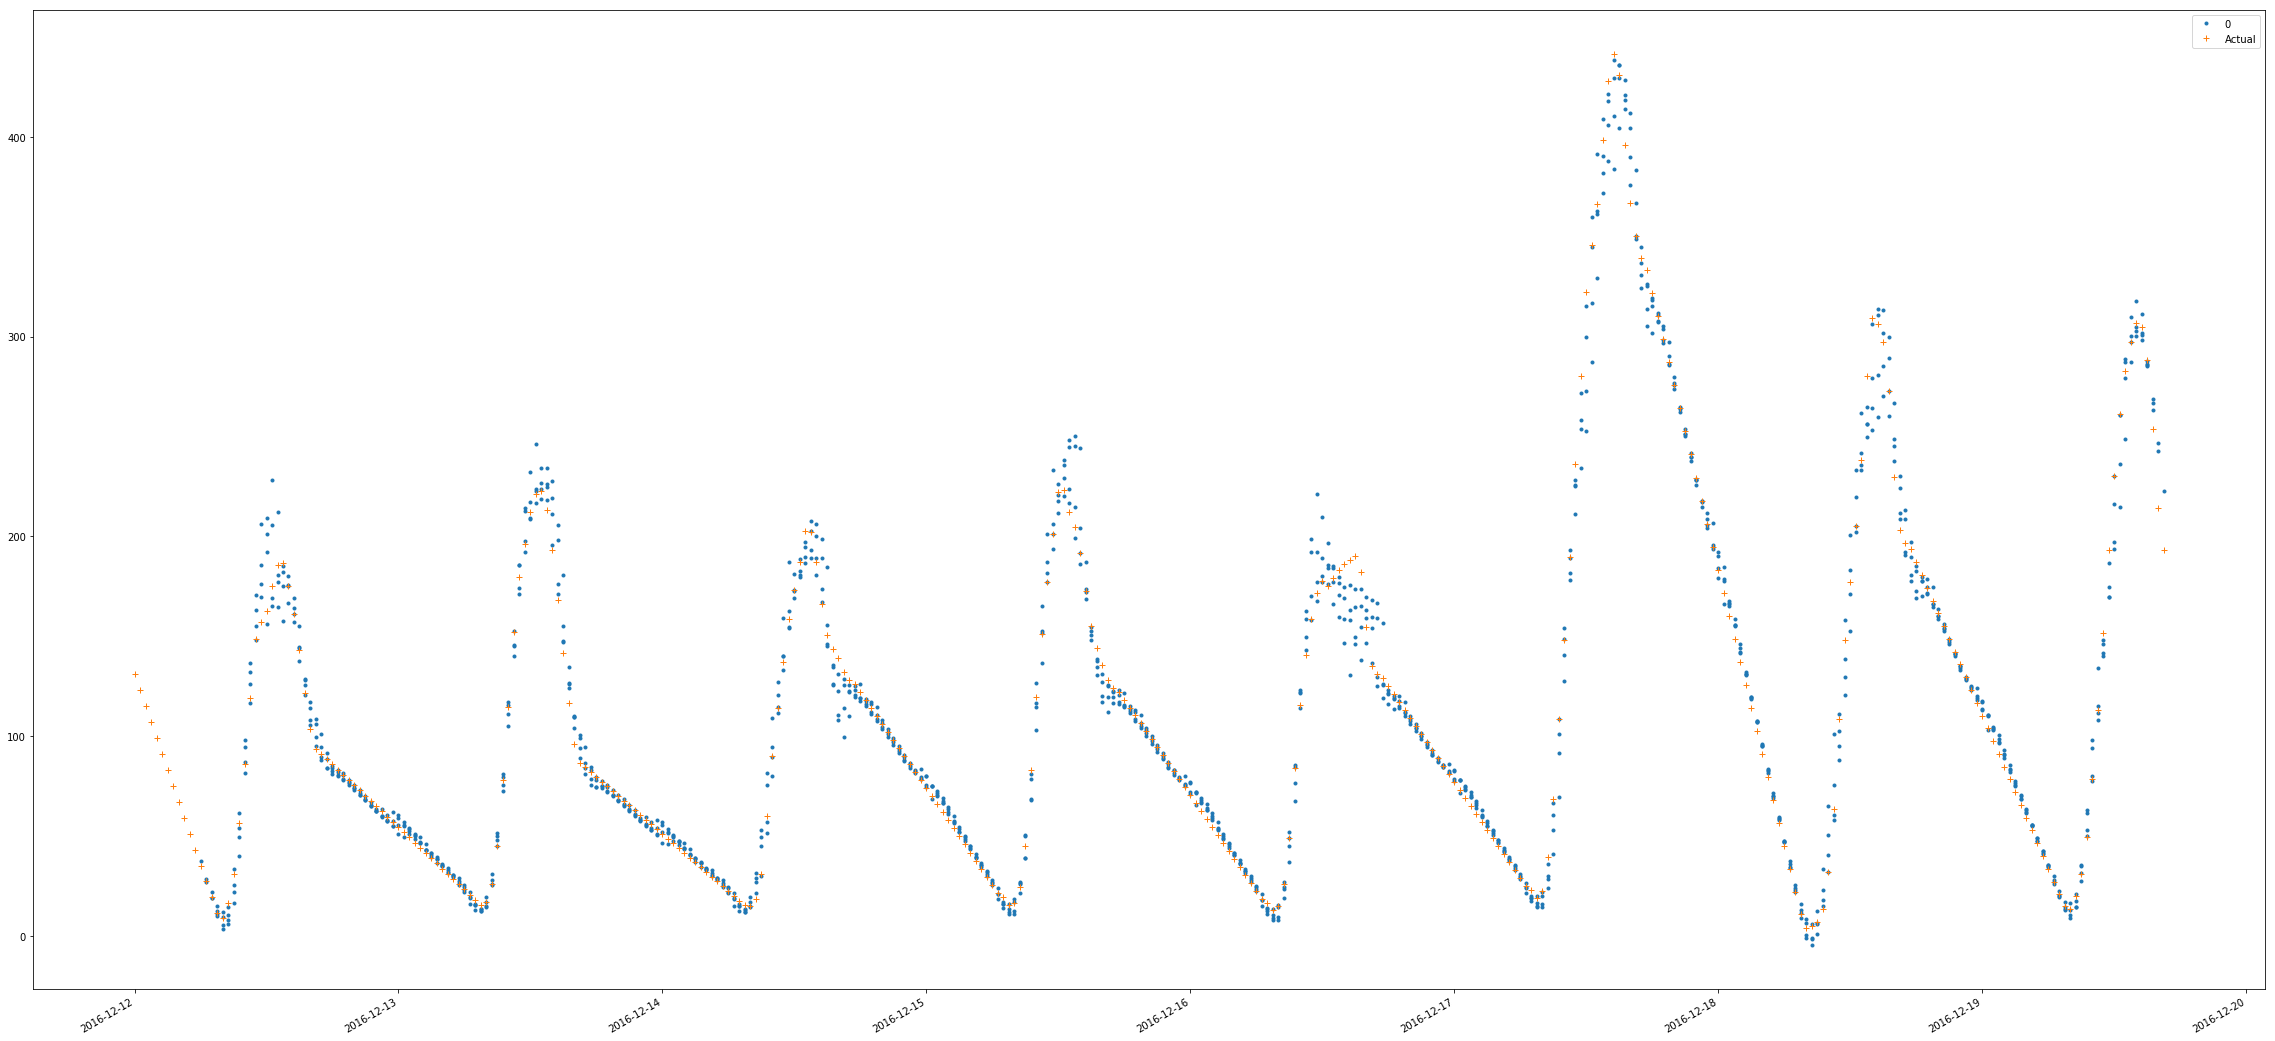

In [49]:
evaluate_model_plot(model, eval_set, n, m, lambda x: ((x + 1.0) / 2.0) * capacity)